In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR

import pandas as pd
import tqdm as notebook_tqdm
from torch.utils.data import DataLoader , ConcatDataset
from torchvision.transforms import ToTensor, Normalize, Compose, Resize
from torchvision.transforms import RandomHorizontalFlip
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from skimage import transform as trans

from xml.sax.xmlreader import IncrementalParser
import yaml
import time

/home/fischer/Desktop/Fischer/Projects/Unico_Challenge/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataloader

In [2]:
from torchvision.datasets import ImageFolder
class ImageFolderWithPaths(ImageFolder):
    """
        Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder

        Facilita para verificar as imagens onde o modelo esta errando/acertando,
    caso desejado
    """
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        #path = self.imgs[index][0]
        #tuple_with_path = (original_tuple + (path,))

        return original_tuple

## Dog Breed Dataloader

In [3]:
class DogBreedDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, img_dir, label, transform):
        'Initialization'
        self.img_dir = img_dir
        self.transform = transform
        self.label = label
    #-------------------------------------------------------
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.label)
    #------------------------------------------------------
    def __getitem__(self, index):
        if self.label is not None:
            img_name = '{}.jpg'.format(self.label.iloc[index, 0])
            fullname = self.img_dir + img_name
            image = Image.open(fullname)
            label = self.label.iloc[index, 1:].astype('float').to_numpy()
            label = np.argmax(label)
            if self.transform: image = self.transform(image)
            return [image, label]

## Preprocessing

In [4]:
def training_val_data(cfg):
    train_transform = Compose ([Resize(cfg['model']['input_size']),
                                RandomHorizontalFlip(),
                                ToTensor(),
                                Normalize(cfg['dataset']['mean'], cfg['dataset']['sigma'])])
    
    val_transform = Compose([Resize(cfg['model']['input_size']),
                            ToTensor(),
                            Normalize(cfg['dataset']['mean'], cfg['dataset']['sigma'])]) 
    
    data_dir = cfg['dataset']['root']

    if(cfg['dataset']['split'] == False):
        train_datasets = ImageFolderWithPaths(os.path.join(data_dir, 'train'), train_transform)
        val_datasets =  ImageFolderWithPaths(os.path.join(data_dir, 'test'), val_transform)
    else: 
        datasets = ImageFolderWithPaths(data_dir, val_transform)
        ds = train_val_dataset(datasets)
        train_datasets = ds['train']
        val_datasets =  ds['val']

    trainloader = DataLoader(dataset=train_datasets,
                                    batch_size=cfg['train']['batch_size'],
                                    shuffle=True,
                                    num_workers=cfg['dataset']['num_workers'],
                                    pin_memory=True)

    valloader = DataLoader(dataset=val_datasets,
                                    batch_size=cfg['val']['batch_size'],
                                    shuffle=True,
                                    num_workers=cfg['dataset']['num_workers'],
                                    pin_memory=True)



    return trainloader,valloader
#======================================================================
def test_multidataset_data(path,cfg):
    test_transform = Compose ([Resize(cfg['model']['input_size']),
                               ToTensor(),
                               Normalize(cfg['dataset']['mean'], cfg['dataset']['sigma'])])
    
    l =[]
    test_datasets1 =  ImageFolderWithPaths(os.path.join(path, 'Validation'), test_transform)
    test_datasets2 =  ImageFolderWithPaths(os.path.join(path, 'Training'),   test_transform)
    l.append(test_datasets1)
    l.append(test_datasets2)
    image_dataset  = ConcatDataset(l)

    
    testloader = DataLoader(dataset=image_dataset,
                            batch_size=cfg['test']['batch_size'],
                            num_workers=2)
    return testloader
#======================================================================
def test_data(path,cfg):
    test_transform = Compose([Resize(cfg['model']['input_size']),
                               ToTensor(),
                               Normalize(cfg['dataset']['mean'], cfg['dataset']['sigma'])])

    test_datasets =  ImageFolderWithPaths(path, test_transform)

    testloader = DataLoader(dataset=test_datasets,
                            batch_size=cfg['test']['batch_size'],
                            num_workers=2)

    return testloader
#======================================================================
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

    



## utils_DeviceDataloader

In [5]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl  # DataLoader obj
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


## utils_eval

In [6]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
#====================================================
def metrics_csv(csv_path, classes):
    df  = pd.read_csv(csv_path)
    labels = df['label']
    scores  = df['pred']
    times = df['inference_time_seconds']

    label_conv = []
    score_conv = []

    for i in range(len(labels)):
        if (labels[i]=="afro-american"): label_conv.append(0)
        elif (labels[i]=="asian"): label_conv.append(1)
        elif (labels[i]=="caucasian"): label_conv.append(2)
        elif (labels[i]=="indian"): label_conv.append(3)

        if (scores[i]=="afro-american"): score_conv.append(0)
        elif (scores[i]=="asian"): score_conv.append(1)
        elif (scores[i]=="caucasian"): score_conv.append(2)
        elif (scores[i]=="indian"): score_conv.append(3)
    
    inference_time = times.sum()/len(times)

    print(classification_report(label_conv, score_conv, target_names=classes))
    print(f"Mean inference time: {inference_time} seconds \n")

##====================================================

## utils_utils

In [7]:
def read_cfg(cfg_file):
    """
    Read configurations from yaml file
    Args:
        cfg_file (.yaml): path to cfg yaml
    Returns:
        (dict): configuration in dict
    """
    with open(cfg_file, 'r') as rf:
        cfg = yaml.safe_load(rf)
        return cfg
#===================================================== 
def save_cfg(cfg_dict, save_path):
    '''
        Save cfg in yaml file
    '''
    with open(save_path, 'w') as yaml_file:
        yaml.dump(cfg_dict, yaml_file, default_flow_style=False)

#====================================================
def get_optimizer(cfg, network):
    """ Get optimizer based on the configuration
    Args:
        cfg (dict): a dict of configuration
        network: network to optimize
    Returns:
        optimizer 
    """
    optimizer = None
    if cfg['train']['optimizer'] == 'adam':
        optimizer = optim.Adam(network.parameters(), lr=cfg['train']['lr'])
    elif cfg['train']['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(network.parameters(), lr=cfg['train']['lr'], momentum = 0.9, weight_decay=0.9)
    elif cfg['train']['optimizer'] == 'SGD':
        optimizer = optim.SGD(network.parameters(),lr = cfg['train']['lr'])
    else:
        raise NotImplementedError

    return optimizer
#=====================================================
def get_device(cfg):
    """ Get device based on configuration
    Args: 
        cfg (dict): a dict of configuration
    Returns:
        torch.device
    """
    device = None
    if len(cfg['device']) <= 1:
        if cfg['device'] == []:
            device = torch.device("cpu")
        elif cfg['device'][0] == 0:
            device = torch.device("cuda:0")
        elif cfg['device'][0] == 1:
            device = torch.device("cuda:1")
    elif len(cfg['device']) > 1:
        # device = [torch.device(f"cuda:{cfg['device'][0]}"), torch.device(f"cuda:{cfg['device'][1]}")]
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        raise NotImplementedError
    # print(f"GPUs found: {device}")
    return device
#====================================================
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
#===================================================
def get_loss_fn(cfg):
    """Get Loss Function"""
    loss_fn = None
    if cfg['train']['loss_fn'] == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss().cuda()
    else:
        raise NotImplementedError
    return loss_fn  
#===================================================
def get_model(cfg):
    """Get Model architeture"""
    network = None
    if cfg['model']['base'] == 'resnet18':
        network = Resnet18(cfg['model']['pretrained'])
    else:
        raise NotImplementedError
    return network
#===================================================
def get_scheduler(cfg, optimizer):
    """Get learning rate scheduler"""
    scheduler = None
    if cfg['scheduler']['type'] == 'None':
        return None
    elif cfg['scheduler']['type'] == 'linear':
        scheduler = StepLR(optimizer,step_size = cfg['scheduler']['step'], gamma = cfg['scheduler']['decay'])
    elif cfg['scheduler']['type'] == 'exponential':
        scheduler = ExponentialLR(optimizer,gamma= cfg['scheduler']['decay'])
    else:
        raise NotImplementedError
    return scheduler

## Base

In [8]:
class BaseTrainer():
    def __init__(self, cfg, network, optimizer, loss_fn, device, trainloader, valloader, writer, lr_scheduler, report): 
        self.cfg = cfg
        self.network = network
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.trainloader = trainloader
        self.valloader = valloader
        self.writer = writer
        self.loss_fn = loss_fn
        self.report = report

## ImageClassificationBase

In [9]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch,loss_fn):
        images, labels = batch 
        out = self(images)          # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        acc = calc_accuracy(out, labels)
        return loss,acc
    
    def validation_step(self, batch,loss_fn):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        acc = calc_accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        

## Resnet18 arch

In [10]:
from Model_arch.ImageClassificationBase import ImageClassificationBase
from torch import nn
from torchvision import models

class Resnet18(ImageClassificationBase):
    def __init__(self, train_flag):
        n_classes = 100
        super().__init__()
        resnet18 = models.resnet18(pretrained=train_flag)
        self.features = nn.Sequential(*list(resnet18.children())[:-1])
        self.classifier = nn.Sequential(nn.Linear(512,n_classes))
    
    def forward(self,xd):
        f = self.features(xd)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

## Train

In [12]:
print("Starting Training")

print("Pytorch Version:" + torch.__version__)
print("Torchvision Version:" + torchvision.__version__)
# print("Cuda Version:" + torch.version.cuda)

cfg_path = "config/dog_rec.yaml"

#Read config file
print(f"Reading config file {cfg_path} ....")
cfg=read_cfg(cfg_file=cfg_path)
print ("Ok" + '\n')

#config GPU device
device = get_device(cfg)
print('Using {} device'.format(device) + '\n')

#config network
print("Load Network...")
network=get_model(cfg)
print("Ok " + "model:" + cfg['model']['base'] + '\n')

# config optimizer
print("Load Optimizer...")
optimizer=get_optimizer(cfg,network)
print("Ok " + "optimizer:" + cfg['train']['optimizer']+ '\n')

#config learning rate scheduler
print("Scheduler Learning rate")
lr_scheduler = get_scheduler(cfg,optimizer)
print("Ok " + "scheduler: " + cfg['scheduler']['type']+ '\n')

#config loss function
print("Load Loss Function")
loss_fn = get_loss_fn(cfg)
print("Ok " + "loss function:" + cfg['train']['loss_fn']+ '\n')

#Split data in training and validation
print("Load training and Validation data...")
trainloader,valloader=training_val_data(cfg)

#load dataloader into GPU
train_dl = DeviceDataLoader(trainloader, device)
val_dl = DeviceDataLoader(valloader, device)
print(f"Training size: {len(trainloader)} batches")
print(f"Validation size: {len(valloader)} batches")
print("Ok"+ '\n')

Starting Training
Pytorch Version:1.11.0+cu113
Torchvision Version:0.12.0+cu113
Reading config file config/dog_rec.yaml ....
Ok

Using cuda:0 device

Load Network...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/fischer/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:04<00:00, 9.85MB/s]

Ok model:resnet18

Load Optimizer...
Ok optimizer:adam

Scheduler Learning rate
Ok scheduler: None

Load Loss Function
Ok loss function:CrossEntropy

Load training and Validation data...
Training size: 217 batches
Validation size: 853 batches
Ok



## Test Dataloader

In [13]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([16, 3, 224, 224]) torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([13, 16, 86, 19, 77, 44, 29, 54, 53, 34, 58, 52, 94, 27, 79, 89])


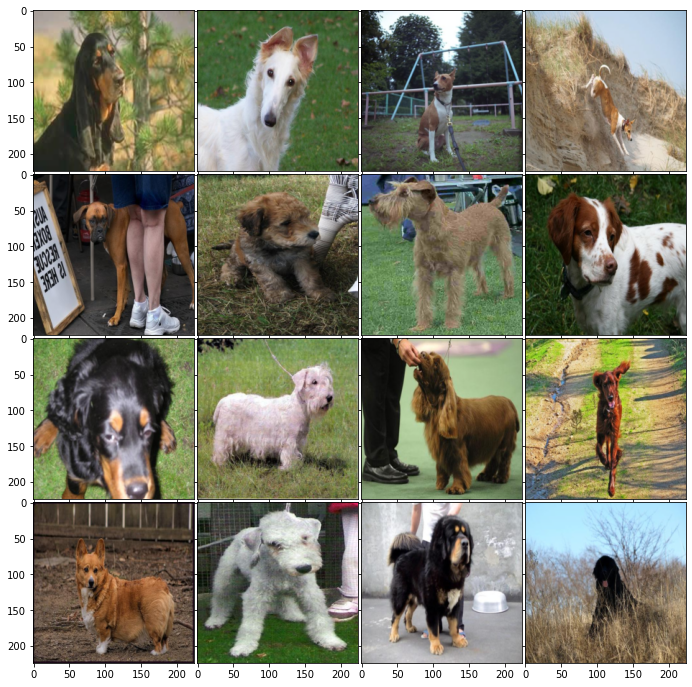

In [18]:
from mpl_toolkits.axes_grid1 import ImageGrid
img, label = next(iter(trainloader))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05) 
print(label)
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])
    